In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble, cross_validation, preprocessing

/home/user/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

1 means the loan was paid.
0 means the loan was defaulted.

In [3]:
df1 = pd.read_csv('Lending Club Without 2007-2009.csv')
df2 = pd.read_csv('Prosper Loan Without 2007-2009.csv')

frame = [df1,df2]
df = pd.concat(frame)
df.columns = ['Filler', 'Loan Amount', 'Employment Length', 'Annual Income', 'Debt-To-Income Ratio',
             'Decision']
df = df.drop(['Filler'],1)
df.describe()

,Loan Amount,Employment Length,Annual Income,Debt-To-Income Ratio,Decision
count,6402875.000,6402875.000,6402875.000,6402875.000,6402875.000
mean,13049.344,2.252,331223.309,4.457,0.150
std,10256.161,2.878,15805890.497,206.817,0.357
min,0.000,0.000,0.000,0.000,0.000
25%,5000.000,1.000,7896.000,0.112,0.000
50%,10000.000,1.000,28884.000,0.238,0.000
75%,20000.000,1.000,68000.000,0.466,0.000
max,1400000.000,62.917,13226400000.000,500000.315,1.000


In [4]:
print np.isnan(df).any()
print ''
print np.isinf(df).any()

Loan Amount             False
Employment Length       False
Annual Income           False
Debt-To-Income Ratio    False
Decision                False
dtype: bool

Loan Amount             False
Employment Length       False
Annual Income           False
Debt-To-Income Ratio    False
Decision                False
dtype: bool


In [5]:
print df[df['Annual Income'] < 1.].count()
print ''

df = df[df['Annual Income'] > 1.]

Loan Amount             8
Employment Length       8
Annual Income           8
Debt-To-Income Ratio    8
Decision                8
dtype: int64



In [6]:
df = df[df['Debt-To-Income Ratio'] < 100000]
df.describe()

,Loan Amount,Employment Length,Annual Income,Debt-To-Income Ratio,Decision
count,6402866.000,6402866.000,6402866.000,6402866.000,6402866.000
mean,13049.354,2.252,329818.153,4.374,0.150
std,10256.161,2.878,15400547.126,60.749,0.357
min,1000.000,0.000,1.200,0.000,0.000
25%,5000.000,1.000,7896.000,0.112,0.000
50%,10000.000,1.000,28884.000,0.238,0.000
75%,20000.000,1.000,68000.000,0.466,0.000
max,1400000.000,62.917,13226400000.000,44088.000,1.000


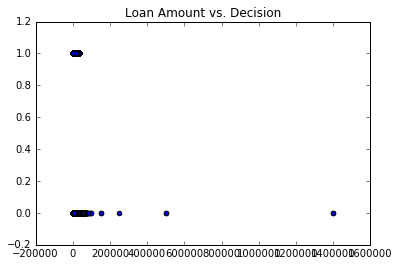

In [7]:
plt.scatter(df['Loan Amount'], df['Decision'])
plt.title('Loan Amount vs. Decision')

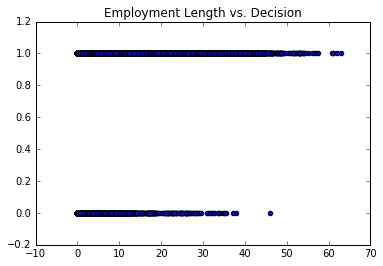

In [8]:
plt.scatter(df['Employment Length'], df['Decision'])
plt.title('Employment Length vs. Decision')

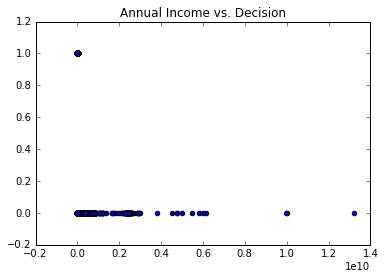

In [9]:
plt.scatter(df['Annual Income'], df['Decision'])
plt.title('Annual Income vs. Decision')

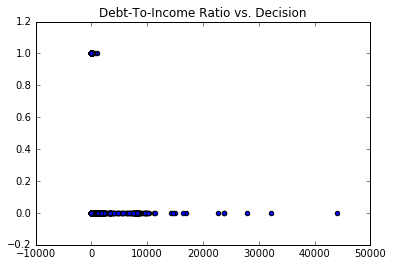

In [10]:
plt.scatter(df['Debt-To-Income Ratio'], df['Decision'])
plt.title('Debt-To-Income Ratio vs. Decision')

# Classification Algorithms


In [11]:
x = np.array(df.drop(['Decision'],1))
y = np.array(df['Decision'])

x_train, x_test, y_train, y_test = cross_validation.train_test_split(x,y,test_size=0.22)

## Gradient Boosting

In [12]:
from sklearn import metrics

Feature importances tell us which features bear more weight in the decision.

In this case, the debt-to-income ratio is roughly a good indicator whether we should give out a loan or not. This is beneficial for us because that ratio is dimensionless, meaning, currency doesn't matter.

Moreover, both employment length and the annual income play equal parts in a decision.

Lastly, it seems that the loan amount is not as important in this model.

GOAL: Reduce the amount of false negatives. Better to falsely accuse a person of defaulting rather than falsely speculating that a person would pay the debt.

In [13]:
clf_gbc = ensemble.GradientBoostingClassifier().fit(x_train,y_train)
print clf_gbc.score(x_test,y_test)
print clf_gbc.feature_importances_

0.997384694785
[ 0.09745787  0.27157932  0.26687432  0.36408849]


In [14]:
y_pred_gbc = clf_gbc.predict(x_test)
print metrics.accuracy_score(y_test,y_pred_gbc)

0.997384694785


In [15]:
print metrics.confusion_matrix(y_test, y_pred_gbc)

confusion_gbc = metrics.confusion_matrix(y_test, y_pred_gbc)
TP_gbc = confusion_gbc[1, 1]
TN_gbc = confusion_gbc[0, 0]
FP_gbc = confusion_gbc[0, 1]
FN_gbc = confusion_gbc[1, 0]

[[1197186     610]
 [   3074  207761]]


In [16]:
# CLASSIFICATION ACCURACY
print (TP_gbc + TN_gbc) / float(TP_gbc + TN_gbc + FP_gbc + FN_gbc)
print metrics.accuracy_score(y_test, y_pred_gbc)

0.997384694785
0.997384694785


In [17]:
# CLASSIFICATION ERROR
print (FP_gbc + FN_gbc) / float(TP_gbc + TN_gbc + FP_gbc + FN_gbc)
print 1 - metrics.accuracy_score(y_test, y_pred_gbc)

0.00261530521478
0.00261530521478


In [18]:
# Sensitivity: How sensitive is the model in predicting positive instances?

print TP_gbc / float(TP_gbc + FN_gbc)
print metrics.recall_score(y_test, y_pred_gbc)

0.985419878104
0.985419878104


In [19]:
# Specificity: When it's actually no, how often does it predict no?
# True Negative Rate

print TN_gbc / float(TN_gbc + FP_gbc)

0.99949073131


In [20]:
# False Positive Rate: When it's actually no, how often does it predict yes?

print FP_gbc / float(TN_gbc + FP_gbc)

0.000509268690161


In [21]:
# Precision: When it predicts yes, how often is it correct?

print TP_gbc / float(TP_gbc + FP_gbc)
print metrics.precision_score(y_test, y_pred_gbc)

0.997072529287
0.997072529287


In [22]:
# F1 Score
print metrics.f1_score(y_test,y_pred_gbc)

0.991211957844


### Probabilities

In [89]:
y_pred_prob_gbc = clf_gbc.predict_proba(x_test)

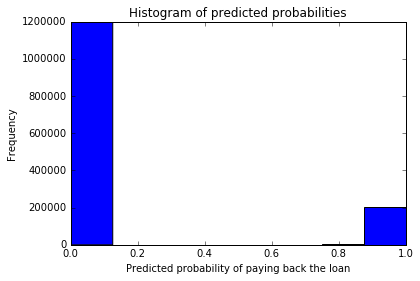

In [90]:
plt.hist(y_pred_prob_gbc[:,1], bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of paying back the loan')
plt.ylabel('Frequency')

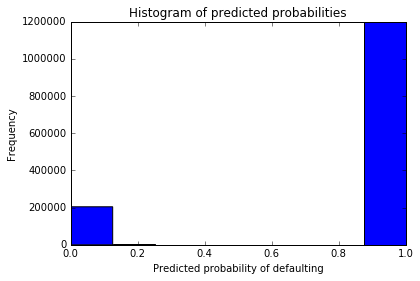

In [91]:
plt.hist(y_pred_prob_gbc[:,0], bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of defaulting')
plt.ylabel('Frequency')

### ROC and AUC

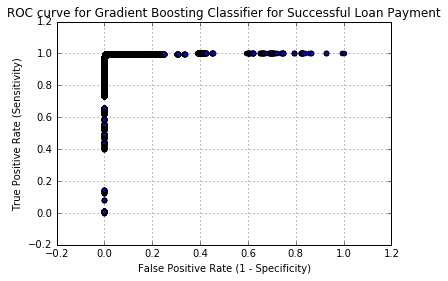

In [123]:
fpr_gbc, tpr_gbc, thresholds_gbc = metrics.roc_curve(y_test, y_pred_prob_gbc[:,1])
plt.scatter(fpr_gbc, tpr_gbc)
plt.title('ROC curve for Gradient Boosting Classifier for Successful Loan Payment')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [122]:
print metrics.roc_auc_score(y_test, y_pred_prob_gbc[:,1])

0.999673438921


## Random Forest

For the Random Forest model, we see that much like the Gradient Boosting Model, loan amount is given less importance than the rest of the explanatory variables.

Moreover, much like the Gradient Boosting model, the debt-to-income ratio bears the most importance in determining loan defaults. This is again an important conclusion because this ratio is dimensionless.

In this model however, more importance is given to the employment length rather than the annual income.

In [28]:
clf_rf = ensemble.RandomForestClassifier().fit(x_train,y_train)
print clf_rf.score(x_test,y_test)
print clf_rf.feature_importances_

0.99944840061
[ 0.01845201  0.12237972  0.06705893  0.79210935]


In [29]:
y_pred_rf = clf_rf.predict(x_test)
print metrics.accuracy_score(y_test, y_pred_rf)

0.99944840061


In [30]:
print metrics.confusion_matrix(y_test, y_pred_rf)

confusion_rf = metrics.confusion_matrix(y_test, y_pred_rf)
TP_rf = confusion_rf[1, 1]
TN_rf = confusion_rf[0, 0]
FP_rf = confusion_rf[0, 1]
FN_rf = confusion_rf[1, 0]

[[1197512     284]
 [    493  210342]]


In [31]:
# CLASSIFICATION ACCURACY
print (TP_rf + TN_rf) / float(TP_rf + TN_rf + FP_rf + FN_rf)
print metrics.accuracy_score(y_test, y_pred_rf)

0.99944840061
0.99944840061


In [32]:
# CLASSIFICATION ERROR
print (FP_rf + FN_rf) / float(TP_rf + TN_rf + FP_rf + FN_rf)
print 1 - metrics.accuracy_score(y_test, y_pred_rf)

0.000551599389762
0.000551599389762


In [33]:
# Sensitivity: How sensitive is the model in predicting positive instances?

print TP_rf / float(TP_rf + FN_rf)
print metrics.recall_score(y_test, y_pred_rf)

0.997661678564
0.997661678564


In [34]:
# Specificity: When it's actually no, how often does it predict no?
# True Negative Rate

print TN_rf / float(TN_rf + FP_rf)

0.999762897856


In [35]:
# False Positive Rate: When it's actually no, how often does it predict yes?

print FP_rf / float(TN_rf + FP_rf)

0.000237102144272


In [36]:
# Precision: When it predicts yes, how often is it correct?

print TP_rf / float(TP_rf + FP_rf)
print metrics.precision_score(y_test, y_pred_rf)

0.998651638449
0.998651638449


In [37]:
# F1 Score
print metrics.f1_score(y_test,y_pred_rf)

0.998156413049


### Probabilities

In [100]:
y_pred_prob_rf = clf_rf.predict_proba(x_test)

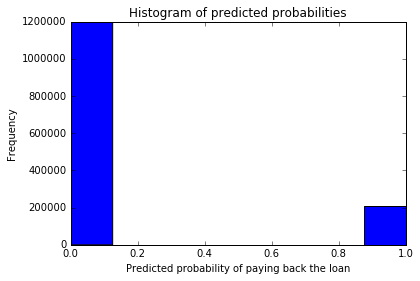

In [101]:
plt.hist(y_pred_prob_rf[:,1], bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of paying back the loan')
plt.ylabel('Frequency')

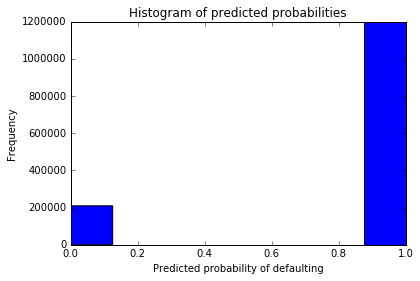

In [102]:
plt.hist(y_pred_prob_rf[:,0], bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of defaulting')
plt.ylabel('Frequency')

### ROC and AUC

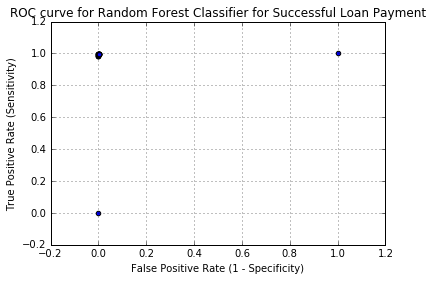

In [119]:
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, y_pred_prob_rf[:,1])
plt.scatter(fpr_rf, tpr_rf)
plt.title('ROC curve for Random Forest Classifier for Successful Loan Payment')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [120]:
print metrics.roc_auc_score(y_test, y_pred_prob_rf[:,1])

0.999744442952


## AdaBoost

The observation that the debt-to-income ratio parameter is a good indicator for loan defaults is again proven here in this model.

However, in this model, we see that the employment length also plays an important role in determining loan defaults, more so than that of the annual income.

Lastly, as we can see yet again, the loan amount parameter plays little role in explaining loan defaults.

In [43]:
clf_ada = ensemble.AdaBoostClassifier().fit(x_train,y_train)
print clf_ada.score(x_test,y_test)
print clf_ada.feature_importances_

0.994604690654
[ 0.06  0.38  0.2   0.36]


In [44]:
y_pred_ada = clf_ada.predict(x_test)
print metrics.accuracy_score(y_test,y_pred_ada)

0.994604690654


In [45]:
print metrics.confusion_matrix(y_test, y_pred_ada)

confusion_ada = metrics.confusion_matrix(y_test, y_pred_ada)
TP_ada = confusion_ada[1, 1]
TN_ada = confusion_ada[0, 0]
FP_ada = confusion_ada[0, 1]
FN_ada = confusion_ada[1, 0]

[[1194822    2974]
 [   4626  206209]]


In [46]:
# CLASSIFICATION ACCURACY
print (TP_ada + TN_ada) / float(TP_ada + TN_ada + FP_ada + FN_ada)
print metrics.accuracy_score(y_test, y_pred_ada)

0.994604690654
0.994604690654


In [47]:
# CLASSIFICATION ERROR
print (FP_ada + FN_ada) / float(TP_ada + TN_ada + FP_ada + FN_ada)
print 1 - metrics.accuracy_score(y_test, y_pred_ada)

0.00539530934645
0.00539530934645


In [48]:
# Sensitivity: How sensitive is the model in predicting positive instances?

print TP_ada / float(TP_ada + FN_ada)
print metrics.recall_score(y_test, y_pred_ada)

0.978058671473
0.978058671473


In [49]:
# Specificity: When it's actually no, how often does it predict no?
# True Negative Rate

print TN_ada / float(TN_ada + FP_ada)

0.997517106419


In [50]:
# False Positive Rate: When it's actually no, how often does it predict yes?

print FP_ada / float(TN_ada + FP_ada)

0.00248289358121


In [51]:
# Precision: When it predicts yes, how often is it correct?

print TP_ada / float(TP_ada + FP_ada)
print metrics.precision_score(y_test, y_pred_ada)

0.985782783496
0.985782783496


In [52]:
# F1 Score
print metrics.f1_score(y_test,y_pred_ada)

0.981905537382


### Probabilities

In [84]:
y_pred_prob_ada = clf_rf.predict_proba(x_test)

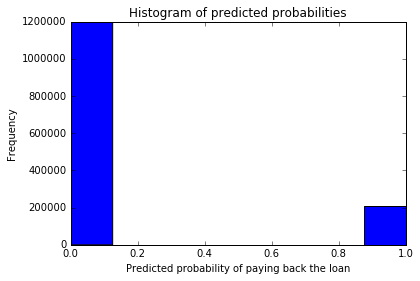

In [85]:
plt.hist(y_pred_prob_ada[:,1], bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of paying back the loan')
plt.ylabel('Frequency')

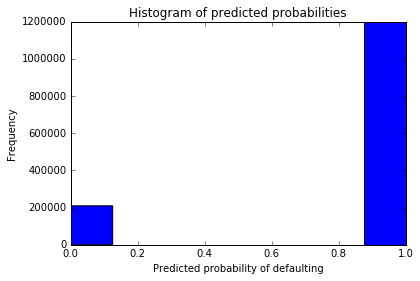

In [86]:
plt.hist(y_pred_prob_ada[:,0], bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of defaulting')
plt.ylabel('Frequency')

### ROC and AUC

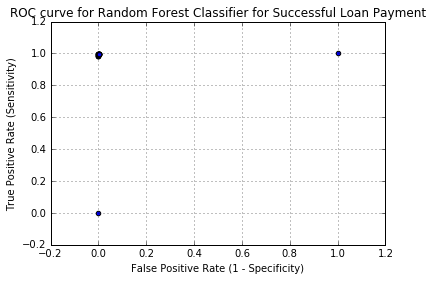

In [117]:
fpr_ada, tpr_ada, thresholds_ada = metrics.roc_curve(y_test, y_pred_prob_ada[:,1])
plt.scatter(fpr_ada, tpr_ada)
plt.title('ROC curve for Random Forest Classifier for Successful Loan Payment')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [118]:
print metrics.roc_auc_score(y_test, y_pred_prob_ada[:,1])

0.999744442952


# Exporting Models

In [61]:
from sklearn.externals import joblib

joblib.dump(clf_gbc, 'Gradient Boosting Model/Gradient Boost Model for Credit Default.cls')
joblib.dump(clf_rf, 'Random Forest Model/Random Forest Model for Credit Default.cls')
joblib.dump(clf_ada, 'AdaBoost Model/AdaBoost Model for Credit Default.cls')

['AdaBoost Model for Credit Default.cls',
 'AdaBoost Model for Credit Default.cls_01.npy',
 'AdaBoost Model for Credit Default.cls_02.npy',
 'AdaBoost Model for Credit Default.cls_03.npy',
 'AdaBoost Model for Credit Default.cls_04.npy',
 'AdaBoost Model for Credit Default.cls_05.npy',
 'AdaBoost Model for Credit Default.cls_06.npy',
 'AdaBoost Model for Credit Default.cls_07.npy',
 'AdaBoost Model for Credit Default.cls_08.npy',
 'AdaBoost Model for Credit Default.cls_09.npy',
 'AdaBoost Model for Credit Default.cls_10.npy',
 'AdaBoost Model for Credit Default.cls_11.npy',
 'AdaBoost Model for Credit Default.cls_12.npy',
 'AdaBoost Model for Credit Default.cls_13.npy',
 'AdaBoost Model for Credit Default.cls_14.npy',
 'AdaBoost Model for Credit Default.cls_15.npy',
 'AdaBoost Model for Credit Default.cls_16.npy',
 'AdaBoost Model for Credit Default.cls_17.npy',
 'AdaBoost Model for Credit Default.cls_18.npy',
 'AdaBoost Model for Credit Default.cls_19.npy',
 'AdaBoost Model for Credit